<a href="https://colab.research.google.com/github/PengZhang1997/Peng_INFO5731_Spring2025/blob/main/Peng_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [18]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import spacy
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import pandas as pd

# Load spaCy language model
nlp = spacy.load("en_core_web_sm")

# Function to fetch reviews from IMDb
def fetch_reviews(movie_id, max_reviews=1000):
    reviews = []
    page = 1
    while len(reviews) < max_reviews:
        url = f"https://www.imdb.com/title/{movie_id}/reviews?ref_=tt_ov_ql_2&page={page}"
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to retrieve page {page} for {movie_id}")
            break
        soup = BeautifulSoup(response.text, 'html.parser')
        review_elements = soup.find_all('div', class_='ipc-html-content-inner-div')
        if not review_elements:
            print(f"No more reviews found for {movie_id}.")
            break
        for review in review_elements:
            reviews.append(review.get_text(strip=True))
        if len(reviews) >= max_reviews:
            break
        time.sleep(2)  # To prevent sending requests too frequently
        page += 1
    print(f"Total reviews collected: {len(reviews)}")
    return reviews[:max_reviews]

# Function to calculate N-gram frequency
def get_ngrams(reviews, n=2):
    all_ngrams = []
    for review in reviews:
        tokens = word_tokenize(review.lower())  # Convert text to lowercase and tokenize
        ngrams_list = ngrams(tokens, n)  # Extract N-grams
        all_ngrams.extend(ngrams_list)
    return Counter(all_ngrams)

# Function to calculate bigram probabilities
def calculate_bigram_probabilities(bigrams, total_bigrams):
    probabilities = {}
    for bigram, count in bigrams.items():
        word1 = bigram[0]
        word2 = bigram[1]
        word1_count = sum([count for (w1, w2), count in bigrams.items() if w1 == word1])  # Count occurrences of word1
        probability = count / word1_count
        probabilities[bigram] = probability
    return probabilities

# Function to extract noun phrases using spaCy
def extract_noun_phrases(reviews):
    noun_phrases = []
    for review in reviews:
        doc = nlp(review)
        for np in doc.noun_chunks:
            noun_phrases.append(np.text.lower())  # Extract noun phrases and convert to lowercase
    return Counter(noun_phrases)

# Function to calculate relative noun phrase probabilities for each review
def calculate_noun_phrase_probabilities_per_review(reviews, noun_phrases_counter):
    max_frequency = max(noun_phrases_counter.values())  # Find the max frequency across all noun phrases
    probabilities_matrix = []

    # For each review, calculate the probability of each noun phrase
    for review in reviews:
        doc = nlp(review)
        review_counter = Counter(np.text.lower() for np in doc.noun_chunks)  # Count noun phrases in review
        probabilities_row = []

        for np, count in noun_phrases_counter.items():
            # Frequency of noun phrase in the current review divided by the max frequency across all reviews
            prob = review_counter.get(np, 0) / max_frequency
            probabilities_row.append(prob)

        probabilities_matrix.append(probabilities_row)

    return probabilities_matrix

# Main execution process
movie_id = "tt13521006"  # Replace with the movie ID you want to fetch reviews for
reviews = fetch_reviews(movie_id, max_reviews=100)  # Fetch reviews

# Get bigrams and trigrams frequency
bigrams = get_ngrams(reviews, n=2)
trigrams = get_ngrams(reviews, n=3)

# Calculate bigram probabilities
bigram_probabilities = calculate_bigram_probabilities(bigrams, len(bigrams))

# Extract noun phrases (this will give a Counter of noun phrases)
noun_phrases_counter = extract_noun_phrases(reviews)  # This is a Counter of noun phrases

# Calculate relative probabilities of noun phrases
noun_phrase_probabilities = {np: count / max(noun_phrases_counter.values()) for np, count in noun_phrases_counter.items()}

# Calculate the probability matrix for noun phrases across reviews
probability_matrix = calculate_noun_phrase_probabilities_per_review(reviews, noun_phrases_counter)

# Create a DataFrame with reviews as rows and noun phrases as columns
noun_phrase_matrix_df = pd.DataFrame(probability_matrix, columns=noun_phrases_counter.keys())

# Save the table of noun phrase probabilities to a CSV file
noun_phrase_matrix_df.to_csv("noun_phrase_matrix.csv", index=False)

# Save the bigram probabilities to a CSV file
bigram_df = pd.DataFrame(bigram_probabilities.items(), columns=["Bigram", "Probability"])
bigram_df.to_csv("bigram_probabilities.csv", index=False)

# Print the first few rows of the DataFrame to verify
print("\n🔹 Noun Phrase Probability Matrix (First 5 rows):")
print(noun_phrase_matrix_df.head())

print("\n🔹 Bigram Probabilities (First 5 rows):")
print(bigram_df.head())

# Print a message indicating that the results are saved
print("🔹 Results have been saved to 'bigram_probabilities.csv' and 'noun_phrase_matrix.csv'.")




Total reviews collected: 110

🔹 Noun Phrase Probability Matrix (First 5 rows):
        you  this movie  a nightmare        it  more sense  your brain  \
0  0.002392    0.001196     0.001196  0.008373    0.001196    0.001196   
1  0.003589    0.000000     0.000000  0.023923    0.000000    0.000000   
2  0.000000    0.001196     0.002392  0.004785    0.000000    0.000000   
3  0.002392    0.001196     0.000000  0.011962    0.000000    0.000000   
4  0.000000    0.000000     0.000000  0.002392    0.000000    0.000000   

   deep emotions     fears    things     guilt  ...  the style  \
0       0.001196  0.001196  0.001196  0.001196  ...        0.0   
1       0.000000  0.000000  0.001196  0.000000  ...        0.0   
2       0.000000  0.000000  0.000000  0.000000  ...        0.0   
3       0.000000  0.000000  0.000000  0.000000  ...        0.0   
4       0.000000  0.000000  0.000000  0.000000  ...        0.0   

   its own monster  a good way  most people  peak absurdism  \
0              0

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [22]:
import math
import numpy as np
import pandas as pd
from collections import Counter
import requests
from bs4 import BeautifulSoup
import csv
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Initialize NLTK components
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess text (remove stopwords, lowercasing, stemming)
def preprocess_text(text):
    # Convert to lowercase, remove stopwords, and apply stemming
    tokens = text.lower().split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Step 1: Fetch reviews from IMDb
def fetch_reviews(movie_id, max_reviews=1000):
    reviews = []
    page = 1
    while len(reviews) < max_reviews:
        url = f"https://www.imdb.com/title/{movie_id}/reviews?ref_=tt_ov_ql_2&page={page}"
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Will raise an HTTPError if the response code is 4xx/5xx
        except requests.RequestException as e:
            print(f"Request failed for page {page} with error: {e}")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        review_elements = soup.find_all('div', class_='ipc-html-content-inner-div')

        if not review_elements:
            print(f"No more reviews found for {movie_id}.")
            break

        for review in review_elements:
            reviews.append(preprocess_text(review.get_text(strip=True)))  # Preprocess each review

        if len(reviews) >= max_reviews:
            break

        time.sleep(2)  # To avoid too frequent requests
        page += 1

    print(f"Total reviews collected: {len(reviews)}")
    return reviews[:max_reviews]

# Save reviews to a CSV file
def save_reviews_to_csv(reviews, filename="Peng.movie_review.csv"):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Review"])
        for review in reviews:
            writer.writerow([review])
    print(f"Reviews saved to {filename}")

# Step 2: Load reviews from CSV
def load_reviews_from_csv(filename="Peng.movie_review.csv"):
    df = pd.read_csv(filename)
    return df['Review'].tolist()

# Function to calculate term frequency (TF) for each document
def calculate_tf(documents):
    tf_list = []
    for doc in documents:
        tokens = doc.split()
        token_count = Counter(tokens)
        total_tokens = len(tokens)
        tf = {word: count / total_tokens for word, count in token_count.items()}
        tf_list.append(tf)
    return tf_list

# Function to calculate inverse document frequency (IDF) for each word
def calculate_idf(documents):
    total_docs = len(documents)
    word_doc_count = Counter()

    for doc in documents:
        unique_words = set(doc.split())
        for word in unique_words:
            word_doc_count[word] += 1

    idf = {}
    for word, doc_count in word_doc_count.items():
        idf[word] = math.log(total_docs / (1 + doc_count))  # Add 1 to avoid division by zero
    return idf

# Function to calculate TF-IDF matrix
def calculate_tfidf(documents):
    tf_list = calculate_tf(documents)
    idf = calculate_idf(documents)

    tfidf_matrix = []
    for tf in tf_list:
        tfidf = {word: tf_val * idf.get(word, 0) for word, tf_val in tf.items()}
        tfidf_matrix.append(tfidf)
    return tfidf_matrix, idf

# Function to calculate cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = sum(vec1.get(word, 0) * vec2.get(word, 0) for word in set(vec1) | set(vec2))
    magnitude_vec1 = math.sqrt(sum(val ** 2 for val in vec1.values()))
    magnitude_vec2 = math.sqrt(sum(val ** 2 for val in vec2.values()))
    return dot_product / (magnitude_vec1 * magnitude_vec2) if magnitude_vec1 and magnitude_vec2 else 0

# Function to rank documents based on a query using cosine similarity
def rank_documents(query, documents, tfidf_matrix, idf):
    query = preprocess_text(query)  # Preprocess the query
    query_tokens = query.split()
    query_word_count = Counter(query_tokens)
    query_tf = {word: count / len(query_tokens) for word, count in query_word_count.items()}
    query_tfidf = {word: query_tf.get(word, 0) * idf.get(word, 0) for word in query_tf}

    similarities = []
    for i, doc_tfidf in enumerate(tfidf_matrix):
        similarity = cosine_similarity(query_tfidf, doc_tfidf)
        similarities.append((i, similarity))

    ranked_docs = sorted(similarities, key=lambda x: x[1], reverse=True)
    return ranked_docs

# Main execution
if __name__ == "__main__":
    # Fetch reviews for the specified movie
    movie_id = "tt13521006"
    reviews = fetch_reviews(movie_id, max_reviews=1000)

    # Save reviews to CSV
    save_reviews_to_csv(reviews)

    # Load the reviews from the CSV file
    reviews = load_reviews_from_csv('Peng.movie_review.csv')

    # Define your query (the query could be anything related to movie reviews)
    query = "An Outstanding movie with a haunting performance and best character development"

    # Calculate TF-IDF for the documents
    tfidf_matrix, idf = calculate_tfidf(reviews)

    # Rank documents based on the query using cosine similarity
    ranked_documents = rank_documents(query, reviews, tfidf_matrix, idf)

    # Display only a portion of the ranked documents (e.g., top 10)
    print("Ranked Documents (Based on Query):")
    for rank, (doc_idx, similarity) in enumerate(ranked_documents[:10], 1):  # Only top 10
        print(f"Rank {rank}: Document {doc_idx+1} - Similarity: {similarity:.4f}")

    # Optionally, print IDF values for debugging
    print("\nIDF values (for debugging):")
    for word, value in idf.items():
        print(f"{word}: {value}")





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total reviews collected: 1012
Reviews saved to Peng.movie_review.csv
Ranked Documents (Based on Query):
Rank 1: Document 15 - Similarity: 0.0805
Rank 2: Document 37 - Similarity: 0.0805
Rank 3: Document 59 - Similarity: 0.0805
Rank 4: Document 81 - Similarity: 0.0805
Rank 5: Document 103 - Similarity: 0.0805
Rank 6: Document 125 - Similarity: 0.0805
Rank 7: Document 147 - Similarity: 0.0805
Rank 8: Document 169 - Similarity: 0.0805
Rank 9: Document 191 - Similarity: 0.0805
Rank 10: Document 213 - Similarity: 0.0805

IDF values (for debugging):
fear: 2.385966701933097
time: 0.785262469467751
movie.it': 3.0576076772720784
review: 1.9877743531540122
also: 0.8940401229393353
creative,: 3.0576076772720784
shot: 3.0576076772720784
viewer: 1.9805015938249324
sum: 2.375155785828881
one,: 3.0576076772720784
movi: 0.09431067947124142
etc.): 3.0576076772720784
summarize,: 3.0576076772720784
base: 2.375155785828881
it.: 1.1394342831883648
(spiders,: 3.0576076772720784
dream,: 2.375155785828881
con

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the word embedding model you created. (PCA and T-sne)

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

Fetching reviews for Shawshank Redemption...
Total reviews collected: 1008
Fetching reviews for The Godfather...
Total reviews collected: 1003
Fetching reviews for The Dark Knight...
Total reviews collected: 1008
Reviews saved to all_movie_reviews.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                              Review  \
0  It is no wonder that the film has such a high ...   
1  I'm trying to save you money; this is the last...   
2  This movie is not your ordinary Hollywood flic...   
3  I have never seen such an amazing film since I...   
4  Can Hollywood, usually creating things for ent...   

                                      Cleaned_Review  
0  wonder film high rate quit liter breathtak say...  
1  im tri save money last film titl consid borrow...  
2  movi ordinari hollywood flick great deep messa...  
3  never seen amaz film sinc saw shawshank redemp...  
4  hollywood usual creat thing entertain purpos c...  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

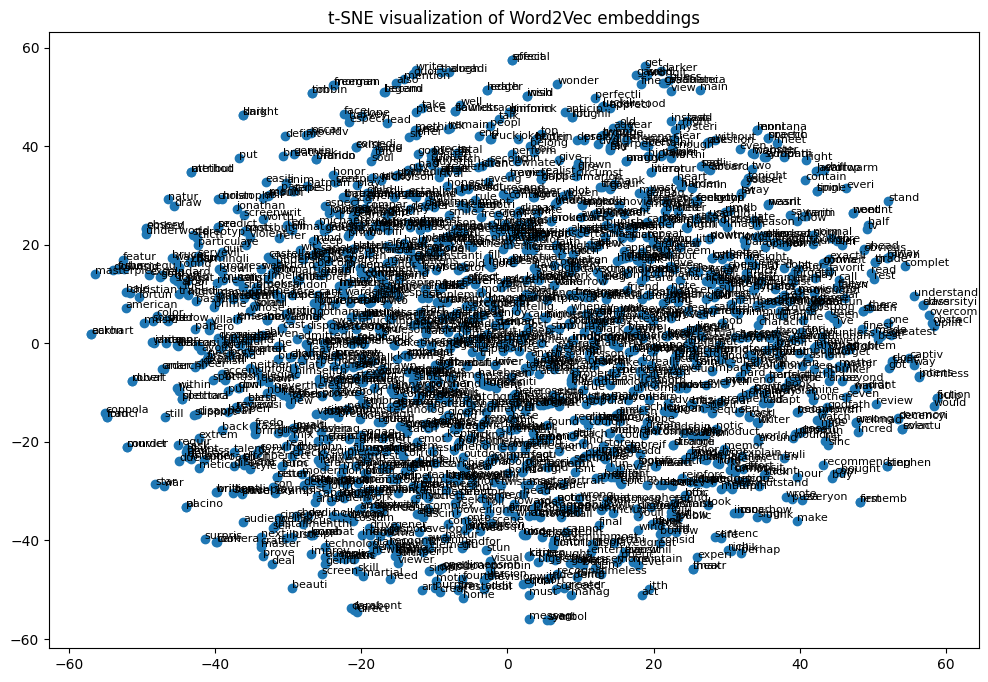

One or both words 'shawshank' and 'redemption' are not in the model.
One or both words 'godfather' and 'mafia' are not in the model.
Similarity between 'joker' and 'batman': 0.494792640209198


In [46]:
from bs4 import BeautifulSoup
import csv
import time

# Fetch reviews for a specific movie
def fetch_reviews(movie_id, max_reviews=1000):
    reviews = []
    page = 1
    while len(reviews) < max_reviews:
        # Construct the pagination URL
        url = f"https://www.imdb.com/title/{movie_id}/reviews?ref_=tt_ov_ql_2&page={page}"
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

        # Send request to the page
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to retrieve page {page} for {movie_id}")
            break

        # Parse the HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all review elements
        review_elements = soup.find_all('div', class_='ipc-html-content-inner-div')

        if not review_elements:
            print(f"No more reviews found for {movie_id}.")
            break

        for review in review_elements:
            reviews.append(review.get_text(strip=True))

        # Check if the desired number of reviews is reached
        if len(reviews) >= max_reviews:
            break

        time.sleep(2)  # Add delay to avoid making too frequent requests
        page += 1

    print(f"Total reviews collected: {len(reviews)}")  # Print the total number of reviews
    return reviews[:max_reviews]

# Save the reviews to a CSV file
def save_reviews_to_csv(reviews, filename="movie_reviews.csv"):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Review"])  # Write the header
        for review in reviews:
            writer.writerow([review])
    print(f"Reviews saved to {filename}")

# Fetch reviews for three movies and combine them into a single list
movie_ids = {
    "Shawshank Redemption": "tt0111161",
    "The Godfather": "tt0068646",
    "The Dark Knight": "tt0468569"
}

all_reviews = []
for movie_name, movie_id in movie_ids.items():
    print(f"Fetching reviews for {movie_name}...")
    reviews = fetch_reviews(movie_id, max_reviews=1000)
    all_reviews.extend(reviews)

# Save all reviews to a CSV file
save_reviews_to_csv(all_reviews, filename="all_movie_reviews.csv")

# Download the CSV file (If you are using Google Colab)
from google.colab import files
files.download('all_movie_reviews.csv')


import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load the CSV file
df = pd.read_csv('all_movie_reviews.csv')

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stop words list
stop_words = set(stopwords.words('english'))

# Data cleaning function
def clean_text(text):
    # (1) Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces

    # (2) Remove numbers
    text = re.sub(r'\d+', '', text)  # Remove digits

    # (3) Remove stop words
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]

    # (4) Convert to lowercase
    text = ' '.join(words).lower()

    # (5) Apply stemming
    words = [stemmer.stem(word) for word in words]  # Apply stemming

    # (6) Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization

    return ' '.join(words)

# Clean each review
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Save cleaned data
df.to_csv('cleaned_movie_reviews.csv', index=False)

# View the cleaned data (first few rows)
print(df[['Review', 'Cleaned_Review']].head())

# Download the cleaned CSV file (if using Google Colab)
from google.colab import files
files.download('cleaned_movie_reviews.csv')


# ----- Word2Vec Model -----
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Load the cleaned review data
df = pd.read_csv('cleaned_movie_reviews.csv')

# Prepare training data: Split each review into a list of words
sentences = [review.split() for review in df['Cleaned_Review']]

# Step 2: Train the Word2Vec model
model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Save the trained model
model.save("movie_reviews_word2vec.model")

# Step 3: Visualize the word embeddings

# Get word vectors for all words
words = list(model.wv.index_to_key)
word_vectors = [model.wv[word] for word in words]

# Use PCA to reduce to 50 dimensions
pca = PCA(n_components=50)
result_pca = pca.fit_transform(word_vectors)

# Use t-SNE to reduce to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=0)
result_tsne = tsne.fit_transform(result_pca)

# Plot the 2D t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(result_tsne[:, 0], result_tsne[:, 1])

# Annotate each word in the plot
for i, word in enumerate(words):
    plt.annotate(word, (result_tsne[i, 0], result_tsne[i, 1]), fontsize=8)

plt.title('t-SNE visualization of Word2Vec embeddings')
plt.show()


# ----- Cosine Similarity -----
# Check if words exist in the model before calculating similarity
if 'shawshank' in model.wv and 'redemption' in model.wv:
    similarity_1 = model.wv.similarity('shawshank', 'redemption')
    print(f"Similarity between 'shawshank' and 'redemption': {similarity_1}")
else:
    print("One or both words 'shawshank' and 'redemption' are not in the model.")

if 'godfather' in model.wv and 'mafia' in model.wv:
    similarity_2 = model.wv.similarity('godfather', 'mafia')
    print(f"Similarity between 'godfather' and 'mafia': {similarity_2}")
else:
    print("One or both words 'godfather' and 'mafia' are not in the model.")

if 'joker' in model.wv and 'batman' in model.wv:
    similarity_3 = model.wv.similarity('joker', 'batman')
    print(f"Similarity between 'joker' and 'batman': {similarity_3}")
else:
    print("One or both words 'joker' and 'batman' are not in the model.")


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [55]:
# The GitHub link of your final csv file：https://github.com/PengZhang1997/Peng_INFO5731_Spring2025/blob/main/Peng.movie_review_with_sentiment%20.csv
#In this task, I collected 50 movie reviews from IMDb. I annotated each review with a sentiment label (Positive, Negative, or Neutral) based on the tone and content of the review.

#The dataset was saved in a CSV file with three columns: document_id, clean_text, and sentiment.

#1. Which NLP Task you would like to perform on your selected dataset (NER, Summarization, Sentiment Analysis, Text Classification)?
#I would like to perform Sentiment Analysis on my selected dataset. The dataset consists of movie reviews where the objective is to classify each review into one of the sentiment categories: Positive, Negative, or Neutral. I have already manually labeled the reviews with sentiment based on the tone and content of each review.

#2. Explain your labeling Schema you have used and mention those labels
#The labeling schema I used is based on the sentiment expressed in each movie review. The sentiment is classified into three categories:
#Positive: Reviews that express a favorable or enthusiastic opinion about the movie. Examples include phrases like "I loved it," "This movie was amazing," and "A fascinating movie with an exceptional ending."
#Negative: Reviews that express dissatisfaction, frustration, or a generally negative view of the movie. Examples include phrases like "The movie broke my brain," "This is Ari Aster's worst film," and "I wasted 3 hours of my life."
#Neutral: Reviews that neither express strong positive nor negative sentiments, and are more neutral or mixed in nature. An example is "Ari Aster still didn't manage to convince me completely."



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Total reviews collected: 66
Reviews with sentiment saved to Peng.movie_review_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer